#Imports

In [ ]:
import librosa
import librosa.feature
import pandas as pd
import csv
import numpy as np
import librosa.display
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
from keras.models import Sequential
import IPython.display as ipd
from keras.layers import Dropout, Dense, Flatten
import warnings
warnings.filterwarnings('ignore')

#Get the data

Directories

In [2]:
main_dir = 'ESC-50-master/'
meta_file = main_dir+'meta/esc50.csv'
audio_dir = main_dir+'audio/'

Use Pandas read_csv to read meta data file and then make the Series of categories of sound and get the list of filenames

In [3]:
meta_data = pd.read_csv(meta_file)
all = meta_data[['target', 'category']].drop_duplicates().sort_values('target').reset_index().drop(['index', 'target'], axis=1)['category']
filenames = meta_data.loc[:,'filename']

All categories

In [4]:
all

0                  dog
1              rooster
2                  pig
3                  cow
4                 frog
5                  cat
6                  hen
7              insects
8                sheep
9                 crow
10                rain
11           sea_waves
12      crackling_fire
13            crickets
14      chirping_birds
15         water_drops
16                wind
17       pouring_water
18        toilet_flush
19        thunderstorm
20         crying_baby
21            sneezing
22            clapping
23           breathing
24            coughing
25           footsteps
26            laughing
27      brushing_teeth
28             snoring
29    drinking_sipping
30     door_wood_knock
31         mouse_click
32     keyboard_typing
33    door_wood_creaks
34         can_opening
35     washing_machine
36      vacuum_cleaner
37         clock_alarm
38          clock_tick
39      glass_breaking
40          helicopter
41            chainsaw
42               siren
43         

#Make a feaure_dataset with 26 fearues

Make mel spectrogram

In [5]:
def make_mel(samples, sample_rate):
  sgram = librosa.stft(samples)
  sgram_mag, _ = librosa.magphase(sgram)
  mel_scale = librosa.feature.melspectrogram(S=sgram_mag, sr=sample_rate)
  mel_sgram = librosa.amplitude_to_db(mel_scale, ref=np.min)
  return mel_sgram

Example

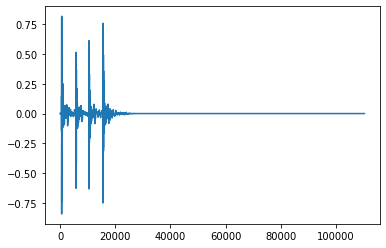

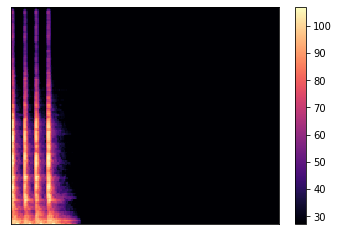

In [6]:
samples, sample_rate = librosa.load(audio_dir + meta_data.loc[10,"filename"])#44100
mel = make_mel(samples, sample_rate)

plt.plot(samples)
plt.show()

librosa.display.specshow(mel)
plt.colorbar()
plt.show()

This function selects 26 features from an audio file and return one row equals to one file

In [7]:
def prepare_data(filename):
  samples, sample_rate = librosa.load(audio_dir+filename)#, mono=True, duration=30)
  y = make_mel(samples, sample_rate)
  # среденее квадратичное для семпла
  rmse = librosa.feature.rms(y=samples)
  # концентрация по классам (цветность)
  chroma_stft = librosa.feature.chroma_stft(y=samples, sr=sample_rate)
  # "центр масс" звука
  spec_cent = librosa.feature.spectral_centroid(y=samples, sr=sample_rate)
  # интервал частот
  spec_bw = librosa.feature.spectral_bandwidth(y=samples, sr=sample_rate)
  # высокие частоты снижаются до 0
  rolloff = librosa.feature.spectral_rolloff(y=samples, sr=sample_rate)
  # количетво пересечений нуля
  zcr = librosa.feature.zero_crossing_rate(samples)
  # mel/Гц
  mfcc = librosa.feature.mfcc(y=samples, sr=sample_rate)
  # one row of dataset
  row = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    

  for i in mfcc:
    row += f' {np.mean(i)}'

  return row.split()


Make a header

In [8]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc_{i}'
header = header.split()

Make a body of dataset

In [10]:
with open(main_dir+'meta/feaure_dataset.csv', 'a', newline='') as filew:
  writer = csv.writer(filew)
  writer.writerow(header)

  for filename in filenames:

    row = prepare_data(filename)
    writer.writerow(row)

Read the new dataset

In [9]:
x = pd.read_csv(main_dir+'meta/feaure_dataset.csv')
y = meta_data['target']

Division into test (25%) and training set with train_test_split

In [10]:
x_train_dataset, x_test_dataset, y_train_dataset, y_test_dataset = train_test_split(x, y, test_size=0.25)

Standardize values

In [11]:
y_train = to_categorical(y_train_dataset, len(all))
y_test = to_categorical(y_test_dataset, len(all))

In [12]:
scaler = StandardScaler()
x_train = scaler.fit_transform(np.array(x_train_dataset.iloc[:, 1:], dtype = float))#iloc[:, 1:-1]
x_test = scaler.fit_transform(np.array(x_test_dataset.iloc[:, 1:], dtype = float))
x_test_dataset = x_test_dataset.reset_index().drop('index', axis=1)

#Sequential model 

In [14]:
model = Sequential([
        # Activation sigmoid + bias          
        Dense(units=250, input_shape=(x_train.shape[1], 1), activation='sigmoid'),
        # Reduse to 0 with p=0.2
        Dropout(rate=0.2),

        Dense(units=200, activation='sigmoid'),
        Dropout(rate=0.5),

        Dense(units=125, activation='relu'),
        Dropout(rate=0.3),

        Dense(units=75, activation='relu'),
        Dropout(rate=0.5),

        Dense(units=50, activation='relu'),
        # Flat input
        Flatten(),

        Dense(units=50, activation='softmax'),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Precision'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 26, 250)           500       
                                                                 
 dropout (Dropout)           (None, 26, 250)           0         
                                                                 
 dense_1 (Dense)             (None, 26, 200)           50200     
                                                                 
 dropout_1 (Dropout)         (None, 26, 200)           0         
                                                                 
 dense_2 (Dense)             (None, 26, 125)           25125     
                                                                 
 dropout_2 (Dropout)         (None, 26, 125)           0         
                                                                 
 dense_3 (Dense)             (None, 26, 75)            9

Trainning the model

In [15]:
model.fit(x_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
38/38 [==============================] - 3s 39ms/step - loss: 4.0094 - accuracy: 0.0275 - precision: 0.0000e+00 - val_loss: 3.9185 - val_accuracy: 0.0133 - val_precision: 0.0000e+00
Epoch 2/100
38/38 [==============================] - 1s 26ms/step - loss: 3.9382 - accuracy: 0.0175 - precision: 0.0000e+00 - val_loss: 3.9206 - val_accuracy: 0.0167 - val_precision: 0.0000e+00
Epoch 3/100
38/38 [==============================] - 1s 28ms/step - loss: 3.9136 - accuracy: 0.0258 - precision: 0.0000e+00 - val_loss: 3.9142 - val_accuracy: 0.0200 - val_precision: 0.0000e+00
Epoch 4/100
38/38 [==============================] - 1s 26ms/step - loss: 3.9195 - accuracy: 0.0242 - precision: 0.0000e+00 - val_loss: 3.9177 - val_accuracy: 0.0133 - val_precision: 0.0000e+00
Epoch 5/100
38/38 [==============================] - 1s 29ms/step - loss: 3.9199 - accuracy: 0.0225 - precision: 0.0000e+00 - val_loss: 3.9144 - val_accuracy: 0.0233 - val_precision: 0.0000e+00
Epoch 6/100
38/38 [===========

#Testing

Testing the model

In [16]:
model.evaluate(x_test, y_test)

16/16 [==============================] - 0s 21ms/step - loss: 3.2397 - accuracy: 0.4300 - precision: 0.4917


[3.2397313117980957, 0.4300000071525574, 0.4917127192020416]

Control the model

In [20]:
# Index of row in x_test
n = 11
# Array shape extension
x0 = np.expand_dims(x_test[n], 0)
# Result of prediction
result = model.predict(x0)
# As softmax result
arg_m = np.argmax(result)
# Define the filenames and audio
x_filename = x_test_dataset['filename'][n]
m_filename = meta_data.filename
samples, sample_rate = librosa.load(audio_dir + x_filename, sr=3000)

print(f'predict num class: {arg_m}\npredict class: {all[arg_m]}\n\n')
print(f"filename: {x_filename}")
print(f"class: {meta_data[m_filename == x_filename]['category'].iloc[0]}")
print(f"num class: {meta_data[m_filename == x_filename]['target'].iloc[0]}\n")

ipd.Audio(samples, rate=sample_rate)

predict num class: 18
predict class: toilet_flush


filename: 5-201664-A-18.wav
class: toilet_flush
num class: 18



In [17]:
all_res = np.argmax( model.predict(x_test) , axis=1)
mask = all_res == np.array(y_test_dataset)
false_res = all_res[~mask]
c = Counter(false_res)
num_class = list(c.keys())[list(c.values()).index(max(c.values()))]
print(f'Наиболее трудный класс: {all[num_class]}')


Наиболее трудный класс: pouring_water
